# **Aula 1 - Preparando os Dados**

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 56.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=9f16c1527f597a9f541654802998ef6950279ec166d9f6765fec225e9c8ea0c6
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


### [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html)

O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet. Para criar uma SparkSession, use o seguinte padrão de construtor:

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master('local[*]')\
    .appName('Regressao com Spark')\
    .getOrCreate()

spark


**Carregamento dos Dados**

### Montando o drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dados = spark.read.parquet(
    '/content/drive/MyDrive/Colab Notebooks/Imercao PySpark/parquet'
)

In [ ]:
dados

DataFrame[andar: bigint, area_total: int, area_util: int, banheiros: int, caracteristicas: array<string>, id: string, quartos: int, suites: int, tipo_anuncio: string, tipo_unidade: string, tipo_uso: string, vaga: int, bairro: string, zona: string, condominio: int, iptu: int, tipo: string, valor: int]

In [ ]:
dados.show(5,truncate=False)

+-----+----------+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|andar|area_total|area_util|banheiros|caracteristicas                                                                                                                |id                                  |quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso   |vaga|bairro   |zona      |condominio|iptu|tipo |valor|
+-----+----------+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|3    |43        |43       |1        |[Academia, Churrasqueira, Pla

In [ ]:
dados.count()

66348

## **Seleção de *Features***

In [ ]:
dados.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: integer (nullable = true)
 |-- iptu: integer (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: integer (nullable = true)



Algumas colunas possuem apenas um único valor. Essas colunas estão dessa forma devido aos filtros que foram realizados na base de dados durante a semana 1. Dessa forma, nós podemos excluir essas colunas, pois como possuem apenas um valor não serão relevantes para o modelo.

In [ ]:
dados\
  .select(
    'tipo_anuncio',
    'tipo_unidade',
    'tipo_uso'
    )\
    .distinct().count()

1

In [ ]:
dados = dados.drop('tipo_anuncio',
    'tipo_unidade',
    'tipo_uso'
    )
dados.select("*").distinct().show(5)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+----+--------------+----------+----------+----+-----+------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|        bairro|      zona|condominio|iptu| tipo| valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+----+--------------+----------+----------+----+-----+------+
|    3|        42|       42|        1|[Condomínio fecha...|986252d5-9f8c-420...|      2|  null|null|Penha Circular|Zona Norte|        88|null|Venda|120000|
|    0|        43|       43|        1|                  []|e1385a2b-2cf6-47d...|      2|     0|   0|     Cascadura|Zona Norte|        50|   0|Venda|130000|
|    0|        82|       82|        2|[Churrasqueira, E...|bc47b8bb-cd79-4be...|      2|     0|   1|    Praça Seca|Zona Oeste|       600| 556|Venda|180000|
|    1|      null|       85|        2|                  []|df3f6

Analise as colunas area_total e area_util. Essas colunas parecem ter muitos valores iguais (conferir isso é importante). Será que é necessário deixar as duas colunas no nosso DataFrame? Qual delas possui mais dados nulos?

In [ ]:
dados\
  .select(
    'area_total',
    'area_util',
    )\
    .where('area_total == area_util' )\
    .count()

55185

55185 resultados de um total de 66348 onde area total e area util sao iguais. Vamos contar quantos valores nulos tem em cada coluna

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
dados.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['area_total','area_util']]).show()

+----------+---------+
|area_total|area_util|
+----------+---------+
|      9186|        0|
+----------+---------+



Podemos observar que 9186 resultados da area total sao nulos e nenhum na area util. Dado que muitos resultados sao iguais vamos manter somente a area util

In [ ]:
  dataset = dados\
  .select(
    "*"
    )\
    .drop('area_total')

## **Converter os tipos das colunas**

Ao analisarmos a estrutura da nossa base de dados, vamos notar que os tipos dos dados de cada coluna estão incorretos e por isso é necessário convertê-los.

In [ ]:
dataset.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: integer (nullable = true)
 |-- iptu: integer (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: integer (nullable = true)



In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

In [ ]:
dataset = dataset\
  .withColumn('andar',dataset['andar'].cast(IntegerType()))\
  .withColumn('area_util',dataset['area_util'].cast(DoubleType()))\
  .withColumn('condominio',dataset['condominio'].cast(DoubleType()))\
  .withColumn('iptu',dataset['iptu'].cast(DoubleType()))\
  .withColumn('valor',dataset['valor'].cast(DoubleType()))

In [ ]:
dataset.show(5)

+-----+---------+---------+--------------------+--------------------+-------+------+----+---------+----------+----------+----+-----+-------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|   bairro|      zona|condominio|iptu| tipo|  valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+---------+----------+----------+----+-----+-------+
|    3|     43.0|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|   1|Paciência|Zona Oeste|     245.0|null|Venda|15000.0|
|    2|     42.0|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|   1|Paciência|Zona Oeste|       0.0| 0.0|Venda|15000.0|
|    1|     41.0|        1|[Portaria 24h, Co...|18d22cbe-1b86-476...|      2|  null|   1|Guaratiba|Zona Oeste|       0.0| 0.0|Venda|20000.0|
|    3|     43.0|        1|[Churrasqueira, P...|bed8a354-9317-442...|      2|  null|   0|   Cosmos|Zona Oeste|     285.0|null|Venda|20000.0|
|    2|     4

## **Tratamento da coluna caracteristicas**

A coluna caracteristicas possui listas de strings como conteúdo de suas linhas. No entanto, algumas dessas listas estão sem elementos.

Vamos transformar essas listas sem elementos em valores nulos.

Dica:

Utilize os recursos da biblioteca functions do PySpark.

In [ ]:
from pyspark.sql.functions import size
dataset = dataset\
  .withColumn('caracteristicas', 
              when(size(col("caracteristicas")) == 0, None)\
              .otherwise(col("caracteristicas")))

### Tratamento para dados faltantes

[Functions](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions)


In [ ]:
from pyspark.sql import functions as f

In [ ]:
dataset.show()

+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+----------+----------+----+-----+-------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|              bairro|      zona|condominio|iptu| tipo|  valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+--------------------+----------+----------+----+-----+-------+
|    3|     43.0|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|   1|           Paciência|Zona Oeste|     245.0|null|Venda|15000.0|
|    2|     42.0|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|   1|           Paciência|Zona Oeste|       0.0| 0.0|Venda|15000.0|
|    1|     41.0|        1|[Portaria 24h, Co...|18d22cbe-1b86-476...|      2|  null|   1|           Guaratiba|Zona Oeste|       0.0| 0.0|Venda|20000.0|
|    3|     43.0|        1|[Churrasqueira, P...|bed8a354-9317-442...|      2|  null|   0

In [ ]:
columnsX = list(dataset.columns).copy()
columnsX.pop(3)

dataset\
  .select([count(when(isnan(c) | col(c).isNull(), True)).alias(c) for c in columnsX])\
  .show()

+-----+---------+---------+---+-------+------+----+------+----+----------+----+----+-----+
|andar|area_util|banheiros| id|quartos|suites|vaga|bairro|zona|condominio|iptu|tipo|valor|
+-----+---------+---------+---+-------+------+----+------+----+----------+----+----+-----+
|    0|        0|        0|  0|      0|  5544|3008|     0|   0|      2347|7155|   0|    0|
+-----+---------+---------+---+-------+------+----+------+----+----------+----+----+-----+



In [ ]:
dataset\
  .select('*')\
  .where((dataset["suites"].isNull())|(dataset["vaga"].isNull())|(dataset["condominio"].isNull())|(dataset["iptu"].isNull()))\
  .show()

+-----+---------+---------+--------------------+--------------------+-------+------+----+------------------+----------+----------+----+-----+-------+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|            bairro|      zona|condominio|iptu| tipo|  valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+------------------+----------+----------+----+-----+-------+
|    3|     43.0|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|   1|         Paciência|Zona Oeste|     245.0|null|Venda|15000.0|
|    2|     42.0|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|   1|         Paciência|Zona Oeste|       0.0| 0.0|Venda|15000.0|
|    1|     41.0|        1|[Portaria 24h, Co...|18d22cbe-1b86-476...|      2|  null|   1|         Guaratiba|Zona Oeste|       0.0| 0.0|Venda|20000.0|
|    3|     43.0|        1|[Churrasqueira, P...|bed8a354-9317-442...|      2|  null|   0|           

In [ ]:
dataset = dataset\
  .select('*')\
  .na\
  .fill(0)

## **Preparação dos dados para machine learning**

Para conseguirmos utilizar nossos dados em modelos de Machine Learning, é necessário realizarmos algumas técnicas, como a transformação de variáveis categóricas em binárias.

Dica:
As colunas caracteristicas e zona parecem ser boas candidatas para o processo de variáveis Dummy

## **Preparação dos Dados**

In [ ]:
dataset = dataset.select("*",f.explode(dataset['caracteristicas'])).drop('caracteristicas')
dataset = dataset.withColumnRenamed('col','caracteristicas')
dataset.show(5)

+-----+---------+---------+--------------------+-------+------+----+---------+----------+----------+----+-----+-------+------------------+
|andar|area_util|banheiros|                  id|quartos|suites|vaga|   bairro|      zona|condominio|iptu| tipo|  valor|   caracteristicas|
+-----+---------+---------+--------------------+-------+------+----+---------+----------+----------+----+-----+-------+------------------+
|    3|     43.0|        1|d2e3a3aa-09b5-45a...|      2|     0|   1|Paciência|Zona Oeste|     245.0| 0.0|Venda|15000.0|          Academia|
|    3|     43.0|        1|d2e3a3aa-09b5-45a...|      2|     0|   1|Paciência|Zona Oeste|     245.0| 0.0|Venda|15000.0|     Churrasqueira|
|    3|     43.0|        1|d2e3a3aa-09b5-45a...|      2|     0|   1|Paciência|Zona Oeste|     245.0| 0.0|Venda|15000.0|        Playground|
|    3|     43.0|        1|d2e3a3aa-09b5-45a...|      2|     0|   1|Paciência|Zona Oeste|     245.0| 0.0|Venda|15000.0|   Salão de festas|
|    3|     43.0|        1|

In [ ]:
dataset\
  .groupBy('id')\
  .pivot('caracteristicas')\
  .agg(f.lit(1))\
  .na\
  .fill(0)\
  .show()

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|                 1|            1|                 0|       0|      1|         1|           0|                0|              1|
|afecddff-f4cc-4ab...|       1|               

In [ ]:
zona = dataset\
  .groupBy('id')\
  .pivot('zona')\
  .agg(f.lit(1))\
  .na\
  .fill(0)

caracteristicas = dataset\
  .groupBy('id')\
  .pivot('caracteristicas')\
  .agg(f.lit(1))\
  .na\
  .fill(0)

In [ ]:
dataset = dataset\
  .join(zona, 'id', how = 'inner')\
  .join(caracteristicas, 'id', how = 'inner')

In [ ]:
dataset = dataset.select('*').drop('zona','bairro','tipo','caracteristicas','')

In [ ]:
dataset.show(5)

+--------------------+-----+---------+---------+-------+------+----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00012605-9cae-45b...|    0|    410.0|        3|      4|     1|   1|    3300.0|5780.0|4600000.0|           0|         0|         0|       1|       0|                 0| 

In [ ]:
dataset.write.parquet(
    path="/content/drive/MyDrive/Colab Notebooks/Imercao PySpark/parquet_ml",
    mode = "overwrite"
    )

## **Preparação dos dados para os algoritmos do Spark MLlib**

Para utilizarmos nossos dados em modelos do PySpark, nós precisamos utilizar a técnica de vetorização dos dados.

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
dataset = dataset.withColumnRenamed('valor','label')

In [ ]:
X = [
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [ ]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [ ]:
dataset_prep = assembler.transform(dataset).select('features','label')

In [ ]:
dataset_prep.show(10,truncate = False)

+-----------------------------------------------------------------------------------------+---------+
|features                                                                                 |label    |
+-----------------------------------------------------------------------------------------+---------+
|(22,[1,2,3,4,5,6,7,11,16],[410.0,3.0,4.0,1.0,1.0,3300.0,5780.0,1.0,1.0])                 |4600000.0|
|(22,[0,1,2,3,5,6,7,9,13,16,20,21],[1.0,50.0,1.0,1.0,1.0,500.0,600.0,1.0,1.0,1.0,1.0,1.0])|360000.0 |
|(22,[0,1,2,3,5,6,7,9,13,16,20,21],[1.0,50.0,1.0,1.0,1.0,500.0,600.0,1.0,1.0,1.0,1.0,1.0])|360000.0 |
|(22,[0,1,2,3,5,6,7,9,13,16,20,21],[1.0,50.0,1.0,1.0,1.0,500.0,600.0,1.0,1.0,1.0,1.0,1.0])|360000.0 |
|(22,[0,1,2,3,5,6,7,9,13,16,20,21],[1.0,50.0,1.0,1.0,1.0,500.0,600.0,1.0,1.0,1.0,1.0,1.0])|360000.0 |
|(22,[1,2,3,4,5,10,14,16,17],[148.0,4.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0])                     |1200000.0|
|(22,[1,2,3,4,5,10,14,16,17],[148.0,4.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0])             

## **Criação dos modelos de regressão**

### Exploracao dos dados

In [ ]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [ ]:
correlacao = Correlation.corr(dataset_prep,'features').collect()[0][0]

In [ ]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

In [ ]:
dataframe_correlacao

,andar,area_util,banheiros,quartos,suites,vaga,condominio,iptu,Zona Central,Zona Norte,...,Academia,Animais permitidos,Churrasqueira,Condomínio fechado,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas
andar,1.000000,0.028103,0.024944,0.016791,0.017845,0.016874,0.004361,-0.000274,0.036728,-0.005071,...,0.026595,0.059550,0.012856,0.049629,0.037333,0.008669,0.017521,0.039459,0.036784,0.020838
area_util,0.028103,1.000000,0.708287,0.674803,0.653126,0.498984,0.054637,0.019715,-0.114792,-0.178557,...,0.009965,-0.023159,-0.028763,-0.011779,0.032502,0.032726,-0.008757,-0.032905,-0.009866,-0.024082
banheiros,0.024944,0.708287,1.000000,0.681862,0.764725,0.457590,0.032265,0.016836,-0.147446,-0.189841,...,0.087649,-0.053207,0.031301,-0.027415,0.059639,0.109611,0.067896,-0.065413,-0.051135,0.054460
quartos,0.016791,0.674803,0.681862,1.000000,0.620531,0.443498,0.024728,0.015873,-0.173617,-0.143050,...,0.075694,-0.030885,0.073725,0.000931,0.036773,0.106559,0.101537,-0.034249,-0.029047,0.080324
suites,0.017845,0.653126,0.764725,0.620531,1.000000,0.447664,0.033086,0.014310,-0.127157,-0.211377,...,0.213983,-0.005136,0.131549,0.076959,0.088714,0.234470,0.147024,0.008363,0.017647,0.126010
vaga,0.016874,0.498984,0.457590,0.443498,0.447664,1.000000,0.028421,0.013556,-0.108510,-0.106706,...,0.107673,-0.011602,0.085402,0.027732,0.026097,0.137882,0.098519,-0.016793,-0.007289,0.094937
condominio,0.004361,0.054637,0.032265,0.024728,0.033086,0.028421,1.000000,0.244134,-0.004968,-0.009950,...,0.008163,0.003537,-0.001957,0.006007,0.004916,0.003827,0.003170,0.002873,-0.002405,0.002470
iptu,-0.000274,0.019715,0.016836,0.015873,0.014310,0.013556,0.244134,1.000000,-0.004333,-0.006780,...,0.000379,-0.004936,-0.004035,-0.008498,-0.004252,0.000242,-0.000727,-0.007001,-0.009371,0.000053
Zona Central,0.036728,-0.114792,-0.147446,-0.173617,-0.127157,-0.108510,-0.004968,-0.004333,1.000000,-0.062865,...,0.041039,0.054661,-0.003246,0.040682,0.031977,0.011899,-0.014831,0.047931,0.044552,-0.000577
Zona Norte,-0.005071,-0.178557,-0.189841,-0.143050,-0.211377,-0.106706,-0.009950,-0.006780,-0.062865,1.000000,...,-0.122777,0.005556,-0.013955,-0.074236,-0.010958,-0.126132,-0.006992,-0.034720,0.004105,0.015241


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

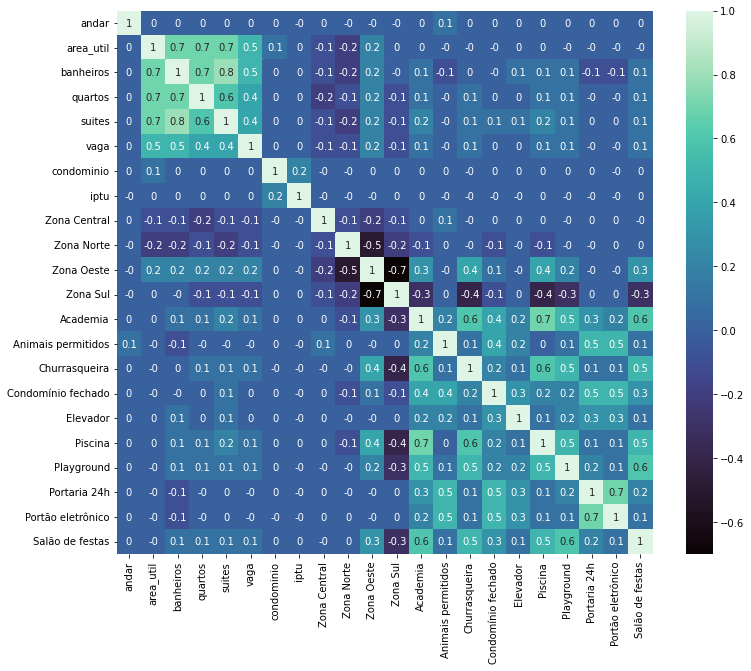

In [ ]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette("mako", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap = paleta)

### Ajuste e Previsao

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
treino, teste = dataset_prep.randomSplit([0.7,0.3], seed = 66)

In [ ]:
treino.count()

228118

In [ ]:
teste.count()

97761

In [ ]:
lr = LinearRegression()

In [ ]:
modelo_lr = lr.fit(treino)

In [ ]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [ ]:
previsoes_lr_treino.show()

+--------------------+---------+-------------------+
|            features|    label|         prediction|
+--------------------+---------+-------------------+
|(22,[0,1,2,3,4,5,...| 262000.0|  666046.4104776479|
|(22,[0,1,2,3,4,5,...| 917000.0|  728147.9351262163|
|(22,[0,1,2,3,4,5,...| 917000.0|  728147.9351262163|
|(22,[0,1,2,3,4,5,...| 560000.0| 1200940.2835970921|
|(22,[0,1,2,3,4,5,...| 560000.0| 1200940.2835970921|
|(22,[0,1,2,3,4,5,...| 560000.0| 1200940.2835970921|
|(22,[0,1,2,3,4,5,...| 730000.0| 1126531.9233383257|
|(22,[0,1,2,3,4,5,...| 816000.0|  738655.9555953065|
|(22,[0,1,2,3,4,5,...| 996000.0|  736658.0383522242|
|(22,[0,1,2,3,4,5,...| 650000.0|  610875.8549585716|
|(22,[0,1,2,3,4,5,...|1485400.0| 1004035.6844227059|
|(22,[0,1,2,3,4,5,...| 220000.0|  779034.4178770737|
|(22,[0,1,2,3,4,5,...| 220000.0|  779034.4178770737|
|(22,[0,1,2,3,4,5,...|  99000.0|-133588.95826879548|
|(22,[0,1,2,3,4,5,...| 620000.0|  73197.61926308423|
|(22,[0,1,2,3,4,5,...| 620000.0|  73197.619263

## **Avaliação dos modelos**

As métricas que vamos utilizar para fazer a avaliação de como nossos modelos estão se comportando são:

RMSE (ou Raiz do Erro Quadrático Médio): é a métrica que calcula a raiz quadrada do erro médio entre os valores reais e as predições da regressão. Quanto menor esse valor, melhor será o modelo, uma vez que estará cometendo menos erros.

R2 (ou coeficiente de determinação): é uma medida estatística que representa a porcentagem de variação da variável resposta que é explicada pelo modelo de regressão. Por se tratar de uma porcentagem, seu valor varia de 0 a 1.

In [ ]:
resumo_treino =  modelo_lr.summary
resumo_teste = modelo_lr.evaluate(teste)

In [ ]:
print("Linear Regression")
print("="*30)
print("Dados de Treino")
print("="*30)
print("R2: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R2: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R2: 0.699822
RMSE: 823649.753738

Dados de Teste
R2: 0.695300
RMSE: 829457.449319


### Decision Tree Regressor

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(seed = 66, maxDepth = 7)

In [ ]:
modelo_dtr = dtr.fit(treino)

In [ ]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [ ]:
previsoes_dtr_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 262000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...| 917000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...| 917000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...| 560000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...| 560000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...| 560000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...| 730000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...| 816000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...| 996000.0|1006852.5104364327|
|(22,[0,1,2,3,4,5,...| 650000.0| 732616.6529680365|
|(22,[0,1,2,3,4,5,...|1485400.0| 1323140.727071211|
|(22,[0,1,2,3,4,5,...| 220000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...| 220000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...|  99000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...| 620000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...| 620000.0| 401162.2504278954|
|(22,[0,1,2,

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino,{evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino,{evaluator.metricName: "rmse"}))

0.8214379764586428
635254.724242968


In [ ]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [ ]:
previsoes_dtr_teste.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(22,[0,1,2,3,4,5,...|262000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...|262000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...|262000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...|917000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...|917000.0| 648244.1554599603|
|(22,[0,1,2,3,4,5,...|560000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...|630000.0|1777303.8208675263|
|(22,[0,1,2,3,4,5,...|420000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...| 99000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...| 99000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...| 99000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...|620000.0| 401162.2504278954|
|(22,[0,1,2,3,4,5,...|690000.0| 732616.6529680365|
|(22,[0,1,2,3,4,5,...|897000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...|897000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...|897000.0| 915441.2203851904|
|(22,[0,1,2,3,4,5,...|529000.0|

In [ ]:
print("Linear Regression")
print("="*30)
print("Dados de Treino")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_dtr_treino,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino,{evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_dtr_teste,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste,{evaluator.metricName: "rmse"}))

Linear Regression
Dados de Treino
R2: 0.821438
RMSE: 635254.724243

Dados de Teste
R2: 0.812515
RMSE: 650641.356730


### Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(seed = 66, maxDepth = 7, numTrees = 10)

In [ ]:
modelo_rfr = rfr.fit(treino)

In [ ]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [ ]:
previsoes_rfr_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 262000.0| 552320.3587925207|
|(22,[0,1,2,3,4,5,...| 917000.0| 591262.2581744991|
|(22,[0,1,2,3,4,5,...| 917000.0| 591262.2581744991|
|(22,[0,1,2,3,4,5,...| 560000.0| 1086804.114786175|
|(22,[0,1,2,3,4,5,...| 560000.0| 1086804.114786175|
|(22,[0,1,2,3,4,5,...| 560000.0| 1086804.114786175|
|(22,[0,1,2,3,4,5,...| 730000.0|1045299.5369743279|
|(22,[0,1,2,3,4,5,...| 816000.0|  579598.567725692|
|(22,[0,1,2,3,4,5,...| 996000.0| 793772.5012001628|
|(22,[0,1,2,3,4,5,...| 650000.0| 660797.6413879948|
|(22,[0,1,2,3,4,5,...|1485400.0|1271084.4983855214|
|(22,[0,1,2,3,4,5,...| 220000.0| 913215.6254756959|
|(22,[0,1,2,3,4,5,...| 220000.0| 913215.6254756959|
|(22,[0,1,2,3,4,5,...|  99000.0|325318.65515837824|
|(22,[0,1,2,3,4,5,...| 620000.0|398296.58664393355|
|(22,[0,1,2,3,4,5,...| 620000.0|398296.58664393355|
|(22,[0,1,2,

In [ ]:
print(evaluator.evaluate(previsoes_rfr_treino,{evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino,{evaluator.metricName: "rmse"}))

0.8291418482649071
621399.9386781567


In [ ]:
previsoes_rfr_teste = modelo_rfr.transform(teste)
previsoes_rfr_teste.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(22,[0,1,2,3,4,5,...|262000.0| 552320.3587925207|
|(22,[0,1,2,3,4,5,...|262000.0| 552320.3587925207|
|(22,[0,1,2,3,4,5,...|262000.0| 552320.3587925207|
|(22,[0,1,2,3,4,5,...|917000.0| 591262.2581744991|
|(22,[0,1,2,3,4,5,...|917000.0| 591262.2581744991|
|(22,[0,1,2,3,4,5,...|560000.0| 1086804.114786175|
|(22,[0,1,2,3,4,5,...|630000.0| 1328308.544976377|
|(22,[0,1,2,3,4,5,...|420000.0|426204.78689023043|
|(22,[0,1,2,3,4,5,...| 99000.0|325318.65515837824|
|(22,[0,1,2,3,4,5,...| 99000.0|325318.65515837824|
|(22,[0,1,2,3,4,5,...| 99000.0|325318.65515837824|
|(22,[0,1,2,3,4,5,...|620000.0|398296.58664393355|
|(22,[0,1,2,3,4,5,...|690000.0| 707351.8562067064|
|(22,[0,1,2,3,4,5,...|897000.0| 1215579.665655269|
|(22,[0,1,2,3,4,5,...|897000.0| 1215579.665655269|
|(22,[0,1,2,3,4,5,...|897000.0| 1215579.665655269|
|(22,[0,1,2,3,4,5,...|529000.0|

In [ ]:
print("Linear Regression")
print("="*30)
print("Dados de Treino")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_rfr_treino,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino,{evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_rfr_teste,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste,{evaluator.metricName: "rmse"}))

Linear Regression
Dados de Treino
R2: 0.829142
RMSE: 621399.938678

Dados de Teste
R2: 0.825038
RMSE: 628535.671746


## **Otimizacao com Cross Validation**

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
lro = LinearRegression()

In [ ]:
grid = ParamGridBuilder()\
  .addGrid(dtr.maxDepth,[2,5,10])\
  .addGrid(dtr.maxBins,[10,32,45])\
  .build()

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
lro_cv = CrossValidator(
    estimator = lro,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds =3,
    seed=66
)

In [ ]:
modelo_lro_cv = lro_cv.fit(treino)

In [ ]:
previsoes_lro_cv_teste = modelo_lro_cv.transform(teste)

In [ ]:
print("Linear Regression")
print("="*30)
print("Dados de Treino")
print("="*30)
print("R2: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_lro_cv_teste,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_lro_cv_teste,{evaluator.metricName: "rmse"}))

Linear Regression
Dados de Treino
R2: 0.695300
RMSE: 829457.449319

Dados de Teste
R2: 0.695300
RMSE: 829457.449319


## **Random Forest com Cross Validation**

In [ ]:
grid = ParamGridBuilder()\
  .addGrid(rfr.numTrees,[10,20,30])\
  .addGrid(rfr.maxDepth,[5,10])\
  .addGrid(rfr.maxBins,[10,32,45])\
  .build()

In [ ]:
rfr_cv = CrossValidator(
    estimator = rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds =3,
)

In [ ]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [ ]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [ ]:
print("Linear Regression")
print("="*30)
print("Dados de Treino")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_rfr_teste,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste,{evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R2: %f" % evaluator.evaluate(previsoes_rfr_cv_teste,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste,{evaluator.metricName: "rmse"}))

Linear Regression
Dados de Treino
R2: 0.825038
RMSE: 628535.671746

Dados de Teste
R2: 0.893407
RMSE: 490595.142623
